# Import

In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import pandas as pd
import numpy as np

In [2]:
merged_df = pd.read_csv('protein_expression.csv')
inputed_columns = ['AGID00215',
 'AGID00537',
 'AGID00536',
 'AGID00211',
 'AGID00485',
 'AGID00383',
 'AGID00216',
 'AGID00257',
 'AGID00545',
 'AGID00413',
 'AGID00547',
 'AGID00144']

In [3]:
protein_columns = merged_df.columns.drop(["ajcc_pathologic_stage","vital_status","days_to_death","days_to_last_follow_up","case_submitter_id"])
protein_columns

Index(['AGID00100', 'AGID00111', 'AGID00101', 'AGID00001', 'AGID00002',
       'AGID00003', 'AGID00443', 'AGID00120', 'AGID00004', 'AGID00005',
       ...
       'AGID00349', 'AGID02137', 'AGID00088', 'AGID00089', 'AGID00504',
       'AGID00095', 'AGID02217', 'AGID02210', 'AGID00326', 'AGID00432'],
      dtype='object', length=468)

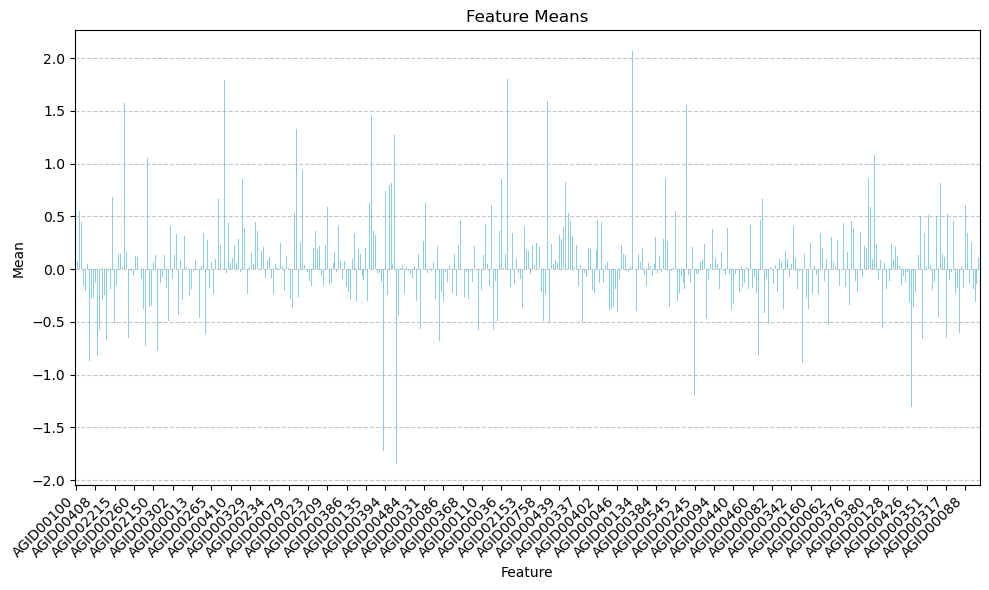

In [4]:
describe_df = merged_df[protein_columns].describe()
row_means = describe_df.loc['mean']

# Plot row means
plt.figure(figsize=(10, 6))
row_means.plot(kind='bar', color='skyblue')
plt.title('Feature Means')
plt.xlabel('Feature')
plt.ylabel('Mean')

plt.xticks(range(0, len(row_means), 10), row_means.index[::10], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

In [5]:
merged_df = merged_df.drop(["ajcc_pathologic_stage","vital_status","days_to_last_follow_up","case_submitter_id"], axis=1)
other = merged_df.columns.drop("days_to_death")

scaler = MinMaxScaler()
merged_df[other] = scaler.fit_transform(merged_df[other])

X_train, X_test, y_train, y_test = train_test_split(merged_df[other], merged_df["days_to_death"],
                                                    train_size=0.75,
                                                    random_state=1)

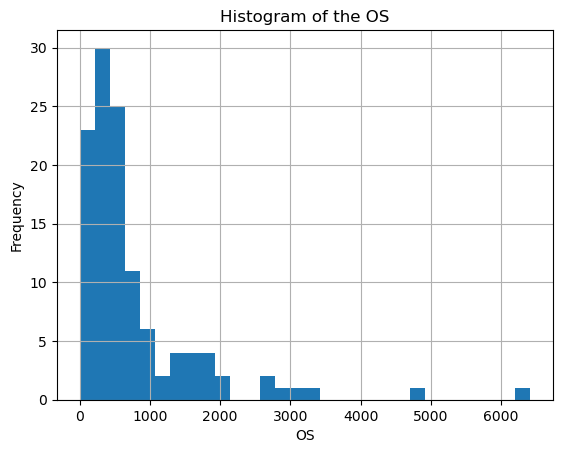

In [6]:
y_train.hist(bins=30) 
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.title('Histogram of the OS')
plt.show()

# AE

In [7]:
class AE():
    def __init__(self,X_train,X_test,y_train,y_test,bottleneck,type):
        self.X_train = X_train
        self.X_test = X_test        
        self.y_train = y_train
        self.y_test = y_test
        self.bottleneck = bottleneck
        self.history = None
        self.encoder = None
        self.autoencoder = None
        self.type = type
        self.classifer = None
        self.cv_score = 0

    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(self.X_test, self.X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()

    def plot(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss '+ self.type)
        plt.legend()
        plt.show()

    def encode(self):
        self.autoencoder.load_weights(f'model/{self.type}_best_model.keras')
        self.encoded_X_train = self.encoder.predict(self.X_train)
        self.encoded_X_test = self.encoder.predict(self.X_test)
    
    def do_PCA(self,n_components):
        if self.bottleneck == 2:
            # pca = PCA(n_components=n_components)
            # reduced_data = pca.fit_transform(self.encoded_X_test)
            x = self.encoded_X_test[:, 0]
            y = self.encoded_X_test[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('Encoded Data '+self.type)
            plt.xlabel('Encoded Dim 0')
            plt.ylabel('Encoded Dim 1')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
            return
        if n_components ==2:
            pca = PCA(n_components=n_components)
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('PCA of Encoded Data '+self.type)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
        elif n_components ==3:
            pca = PCA(n_components=3)  # Reduce to 3 dimensions
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            z = reduced_data[:, 2]
            fig =plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(x, y, z, c=self.y_test_in_bin, cmap='viridis', depthshade=True)
            ax.set_title('3D PCA of Encoded Data '+self.type)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            plt.colorbar(scatter, label='OS')
            plt.show()

    @staticmethod
    def map_years_to_group(value):
        years = value / 365
        if years <= 1:
            return 0
        elif 1 < years <= 3:
            return 1
        elif 3 < years <= 5:
            return 2
        elif 5 < years <= 10:
            return 3
        elif 10 < years <= 20:
            return 4
        else:  
            return 5
        
    @staticmethod        
    def map_to_binary(category):
        if category >= 4:
            return 1
        else:  
            return 0
        
    def map_y(self):
        self.y_trian_in_category = self.y_train.map(AE.map_years_to_group)
        self.y_test_in_category = self.y_test.map(AE.map_years_to_group)        
        
        self.y_trian_in_bin = self.y_trian_in_category.map(AE.map_to_binary)
        self.y_test_in_bin = self.y_test_in_category.map(AE.map_to_binary)

    def cross_validation_model_selection(self,fold=10):
        classifiers = {
            'LogisticRegression': LogisticRegression(),
            'SVM': SVC(),
            'RandomForest': RandomForestClassifier(),
            'KNN': KNeighborsClassifier(),
            'GradientBoosting': GradientBoostingClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'NaiveBayes': GaussianNB(),
            'DecisionTree': DecisionTreeClassifier(),
            'ExtraTrees': ExtraTreesClassifier(),
            'XGBoost': xgb.XGBClassifier()
        }

        kf = KFold(n_splits=fold)
        best_cv_score = 0


        for name, clf in classifiers.items():
            cv_scores = []
            confusion_matrices = []

            for train_index, test_index in kf.split(self.encoded_X_train):
                X_train, X_test = self.encoded_X_train[train_index], self.encoded_X_train[test_index]
                y_train, y_test = self.y_trian_in_bin.iloc[train_index], self.y_trian_in_bin.iloc[test_index]

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                
                cv_scores.append(accuracy_score(y_test, y_pred))
                confusion_matrices.append(confusion_matrix(y_test, y_pred))

            mean_cv_score = np.mean(cv_scores)
            mean_conf_matrix = np.mean(confusion_matrices, axis=0)

            print(f"{name} - Mean CV Score: {mean_cv_score}")
            print(f"{name} - Mean Confusion Matrix:\n{mean_conf_matrix}")

            if mean_cv_score > best_cv_score:
                best_cv_score = mean_cv_score
                best_classifier = name

        self.cv_score = best_cv_score
        print(f"Type: {self.type}, Best classifier: {best_classifier}, CV Score: {best_cv_score}")



    def cross_validation_hyperparameter_optimization(self,fold=5):
        pass


    def do_RF(self,binary):
        clf = RandomForestClassifier(n_estimators=100, random_state=0)

        if binary:
            clf.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))

        else:
            clf.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('RF Confusion Matrix '+self.type)
        plt.show()
        self.classifer = clf

    def do_Kmean(self):
        # Number of clusters - assuming you want as many as your known classes
        num_clusters = 2
        # Perform K-means clustering on the PCA output
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(self.encoded_X_test)  # Use your 2D or 3D PCA-reduced data here


        print("Classification Report:")
        print(classification_report(self.y_test_in_bin, cluster_labels))
        conf_mat = confusion_matrix(self.y_test_in_bin, cluster_labels)

        # Plotting the confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('K-mean Confusion Matrix '+self.type)
        plt.show()
        self.classifer = kmeans

    def do_SVM(self,binary):
        svm_classifier = SVC(kernel='linear',random_state=0)
        # Load the best weights into the autoencoder model
        if binary:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.type)
            plt.show()
        else:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))
        
            # Plotting the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_category))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.type)
            plt.show()
        self.classifer = svm_classifier





In [8]:
class Wider_AE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)

        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(self.X_test, self.X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()       


In [ ]:
class SAE(AE):
    def train(self):

        n_features = len(self.X_train.columns)

        # Define the encoder
        input_layer = Input(shape=(n_features,))
        # Add L1 regularization to encourage sparsity
        encoder = Dense(64, activation='relu', 
                        activity_regularizer=regularizers.l1(1e-6))(input_layer)  # Adjust regularization rate as needed
        encoder = Dense(32, activation='relu', 
                        activity_regularizer=regularizers.l1(1e-6))(encoder)  # Adjust regularization rate as needed

        # Define the bottleneck
        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder = Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        # Callback to save the best model
        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

        # Train the autoencoder
        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                epochs=200,
                batch_size=8,
                shuffle=True,
                validation_data=(self.X_test, self.X_test),
                callbacks=[self.checkpoint])  
        self.encode()
        self.map_y()



# Dispatcher

In [ ]:
def dispatcher(model,min_bottleneck, max_bottleneck,step =2):
    current_size = min_bottleneck
    AEs = []
    while current_size < max_bottleneck:
        name = f"bottleneck {current_size}"
        AEs.append(model(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = current_size,type = name))
        current_size += step
    for untrained_AE in AEs:
        untrained_AE.train()
        untrained_AE.cross_validation_model_selection()
    

In [ ]:
dispatcher(AE,6,48)

In [ ]:
dispatcher(Wider_AE,6,48)

Epoch 1/100
23/31 [=====================>........] - ETA: 0s - loss: 0.0405 
Epoch 1: val_loss improved from inf to 0.02438, saving model to model\(569 proteins encode to 6)_best_model.keras
31/31 [==============================] - 2s 14ms/step - loss: 0.0373 - val_loss: 0.0244
Epoch 2/100
22/31 [====================>.........] - ETA: 0s - loss: 0.0236
Epoch 2: val_loss improved from 0.02438 to 0.02235, saving model to model\(569 proteins encode to 6)_best_model.keras
31/31 [==============================] - 0s 6ms/step - loss: 0.0238 - val_loss: 0.0223
Epoch 3/100
23/31 [=====================>........] - ETA: 0s - loss: 0.0218
Epoch 3: val_loss improved from 0.02235 to 0.02047, saving model to model\(569 proteins encode to 6)_best_model.keras
31/31 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0205
Epoch 4/100
21/31 [===================>..........] - ETA: 0s - loss: 0.0208
Epoch 4: val_loss improved from 0.02047 to 0.01882, saving model to model\(569 prot

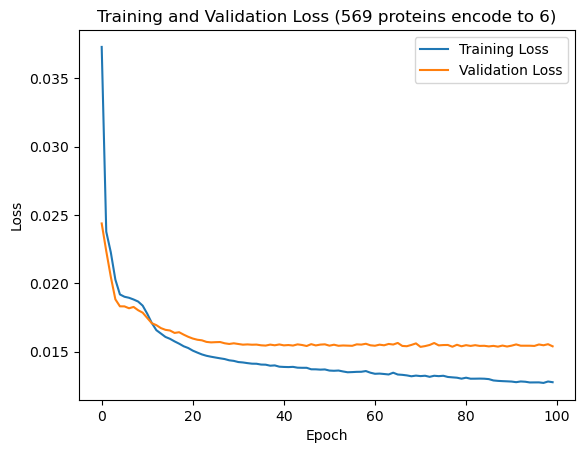

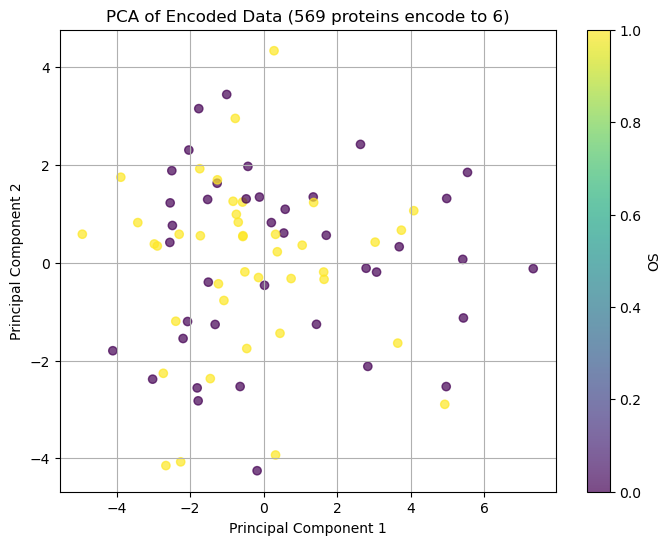

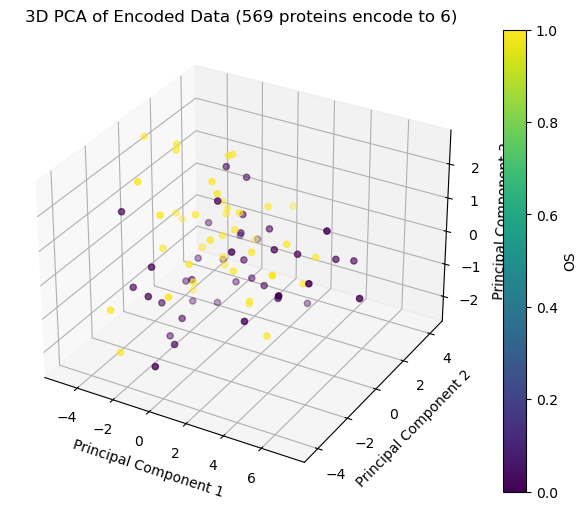

LogisticRegression - Mean CV Score: 0.4486666666666667
LogisticRegression - Mean Confusion Matrix:
[[3.8 7.8]
 [5.6 7.1]]
SVM - Mean CV Score: 0.5323333333333334
SVM - Mean Confusion Matrix:
[[7.4 4.2]
 [7.2 5.5]]
RandomForest - Mean CV Score: 0.5694999999999999
RandomForest - Mean Confusion Matrix:
[[6.4 5.2]
 [5.3 7.4]]
KNN - Mean CV Score: 0.5765
KNN - Mean Confusion Matrix:
[[7.3 4.3]
 [6.  6.7]]
GradientBoosting - Mean CV Score: 0.5818333333333333
GradientBoosting - Mean Confusion Matrix:
[[6.7 4.9]
 [5.3 7.4]]
AdaBoost - Mean CV Score: 0.5726666666666667
AdaBoost - Mean Confusion Matrix:
[[6.6 5. ]
 [5.4 7.3]]
NaiveBayes - Mean CV Score: 0.5488333333333333
NaiveBayes - Mean Confusion Matrix:
[[8.1 3.5]
 [7.5 5.2]]
DecisionTree - Mean CV Score: 0.5403333333333332
DecisionTree - Mean Confusion Matrix:
[[5.9 5.7]
 [5.5 7.2]]
ExtraTrees - Mean CV Score: 0.5611666666666666
ExtraTrees - Mean Confusion Matrix:
[[7.  4.6]
 [6.1 6.6]]
XGBoost - Mean CV Score: 0.5845
XGBoost - Mean Confusi

In [59]:
AE_inputation = AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 6,type = "(569 proteins encode to 6)")
AE_inputation.train()
AE_inputation.plot()
AE_inputation.do_PCA(2)
AE_inputation.do_PCA(3)
AE_inputation.cross_validation_model_selection()

In [60]:
class Wider_AE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)

        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(self.X_test, self.X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()       


Epoch 1/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0380 
Epoch 1: val_loss improved from inf to 0.02355, saving model to model\(569 proteins encode to 12)_best_model.keras
31/31 [==============================] - 2s 16ms/step - loss: 0.0321 - val_loss: 0.0235
Epoch 2/100
18/31 [================>.............] - ETA: 0s - loss: 0.0240
Epoch 2: val_loss improved from 0.02355 to 0.02223, saving model to model\(569 proteins encode to 12)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0237 - val_loss: 0.0222
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.0221
Epoch 3: val_loss improved from 0.02223 to 0.01956, saving model to model\(569 proteins encode to 12)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0221 - val_loss: 0.0196
Epoch 4/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0195
Epoch 4: val_loss improved from 0.01956 to 0.01866, saving model to model\(569 p

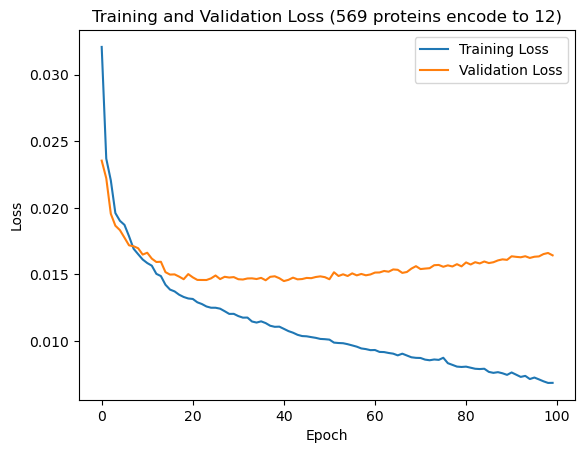

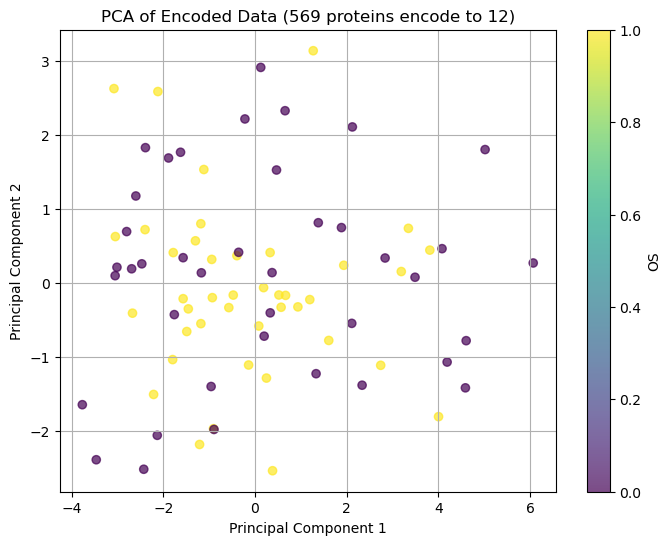

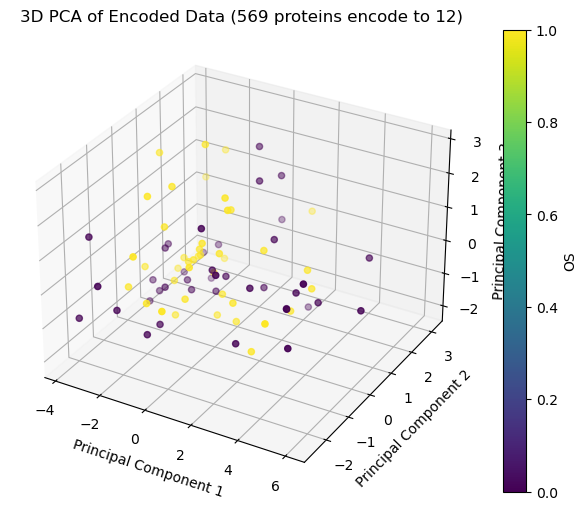

LogisticRegression - Mean CV Score: 0.5349999999999999
LogisticRegression - Mean Confusion Matrix:
[[5.6 6. ]
 [5.3 7.4]]
SVM - Mean CV Score: 0.5885
SVM - Mean Confusion Matrix:
[[5.6 6. ]
 [4.  8.7]]
RandomForest - Mean CV Score: 0.5730000000000001
RandomForest - Mean Confusion Matrix:
[[6.  5.6]
 [4.8 7.9]]
KNN - Mean CV Score: 0.5351666666666667
KNN - Mean Confusion Matrix:
[[6.5 5.1]
 [6.2 6.5]]
GradientBoosting - Mean CV Score: 0.6261666666666666
GradientBoosting - Mean Confusion Matrix:
[[6.9 4.7]
 [4.4 8.3]]
AdaBoost - Mean CV Score: 0.5486666666666666
AdaBoost - Mean Confusion Matrix:
[[6.  5.6]
 [5.4 7.3]]
NaiveBayes - Mean CV Score: 0.5688333333333334
NaiveBayes - Mean Confusion Matrix:
[[7.2 4.4]
 [6.1 6.6]]
DecisionTree - Mean CV Score: 0.5521666666666667
DecisionTree - Mean Confusion Matrix:
[[6.1 5.5]
 [5.4 7.3]]
ExtraTrees - Mean CV Score: 0.6101666666666666
ExtraTrees - Mean Confusion Matrix:
[[6.4 5.2]
 [4.3 8.4]]
XGBoost - Mean CV Score: 0.6293333333333334
XGBoost - 

In [61]:
WAE_inputation_12d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 12,type = "(569 proteins encode to 12)")
WAE_inputation_12d.train()
WAE_inputation_12d.plot()
WAE_inputation_12d.do_PCA(2)
WAE_inputation_12d.do_PCA(3)
WAE_inputation_12d.cross_validation_model_selection()



Epoch 1/100
25/31 [=======================>......] - ETA: 0s - loss: 0.0326
Epoch 1: val_loss improved from inf to 0.02290, saving model to model\(569 proteins encode to 24)_best_model.keras
31/31 [==============================] - 3s 18ms/step - loss: 0.0309 - val_loss: 0.0229
Epoch 2/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0230
Epoch 2: val_loss improved from 0.02290 to 0.02215, saving model to model\(569 proteins encode to 24)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0234 - val_loss: 0.0222
Epoch 3/100
18/31 [================>.............] - ETA: 0s - loss: 0.0231
Epoch 3: val_loss improved from 0.02215 to 0.02048, saving model to model\(569 proteins encode to 24)_best_model.keras
31/31 [==============================] - 0s 7ms/step - loss: 0.0223 - val_loss: 0.0205
Epoch 4/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0207
Epoch 4: val_loss improved from 0.02048 to 0.01873, saving model to model\(569 pr

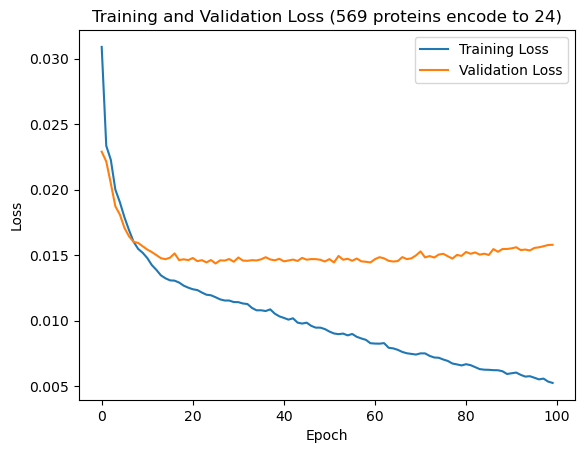

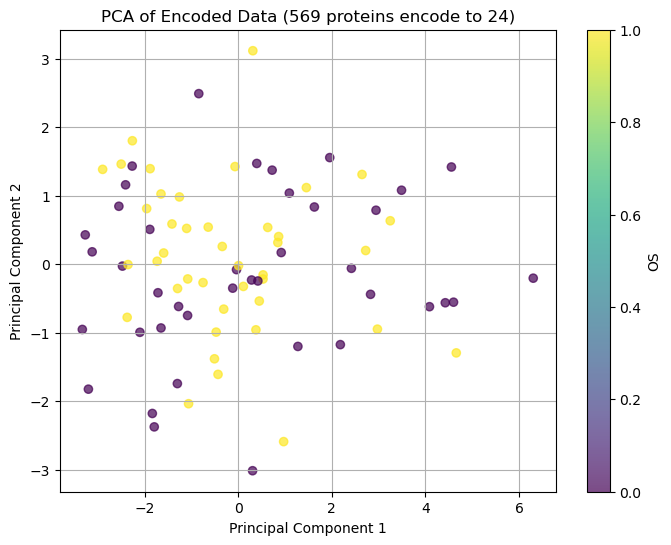

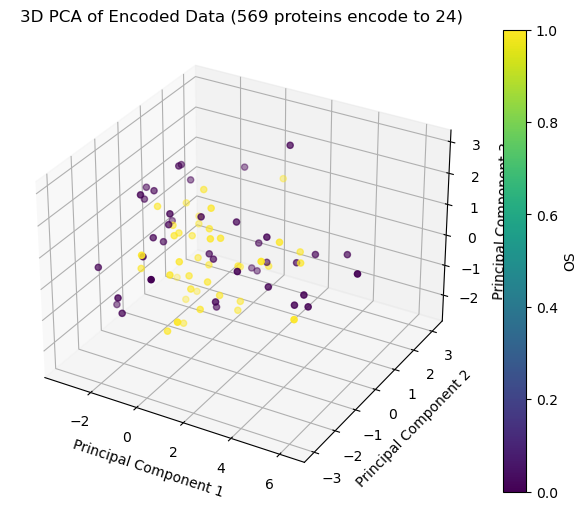

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5843333333333334
LogisticRegression - Mean Confusion Matrix:
[[6.1 5.5]
 [4.6 8.1]]
SVM - Mean CV Score: 0.6010000000000001
SVM - Mean Confusion Matrix:
[[5.9 5.7]
 [4.  8.7]]
RandomForest - Mean CV Score: 0.5803333333333334
RandomForest - Mean Confusion Matrix:
[[5.8 5.8]
 [4.4 8.3]]
KNN - Mean CV Score: 0.6218333333333333
KNN - Mean Confusion Matrix:
[[7.8 3.8]
 [5.4 7.3]]
GradientBoosting - Mean CV Score: 0.5393333333333333
GradientBoosting - Mean Confusion Matrix:
[[5.7 5.9]
 [5.3 7.4]]
AdaBoost - Mean CV Score: 0.535
AdaBoost - Mean Confusion Matrix:
[[5.6 6. ]
 [5.3 7.4]]
NaiveBayes - Mean CV Score: 0.5055000000000001
NaiveBayes - Mean Confusion Matrix:
[[ 0.7 10.9]
 [ 1.1 11.6]]
DecisionTree - Mean CV Score: 0.5225
DecisionTree - Mean Confusion Matrix:
[[5.6 6. ]
 [5.6 7.1]]
ExtraTrees - Mean CV Score: 0.6053333333333334
ExtraTrees - Mean Confusion Matrix:
[[6.8 4.8]
 [4.8 7.9]]
XGBoost - Mean CV Score: 0.5923333333333333
XGBoost - Mean Conf

In [62]:
WAE_inputation_24d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 24,type = "(569 proteins encode to 24)")
WAE_inputation_24d.train()
WAE_inputation_24d.plot()
WAE_inputation_24d.do_PCA(2)
WAE_inputation_24d.do_PCA(3)
WAE_inputation_24d.cross_validation_model_selection()


Epoch 1/100
30/31 [============================>.] - ETA: 0s - loss: 0.0317
Epoch 1: val_loss improved from inf to 0.02317, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 2s 17ms/step - loss: 0.0316 - val_loss: 0.0232
Epoch 2/100
30/31 [============================>.] - ETA: 0s - loss: 0.0237
Epoch 2: val_loss improved from 0.02317 to 0.02231, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0236 - val_loss: 0.0223
Epoch 3/100
18/31 [================>.............] - ETA: 0s - loss: 0.0229
Epoch 3: val_loss improved from 0.02231 to 0.02113, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0228 - val_loss: 0.0211
Epoch 4/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0205
Epoch 4: val_loss improved from 0.02113 to 0.01881, saving model to model\(569 pr

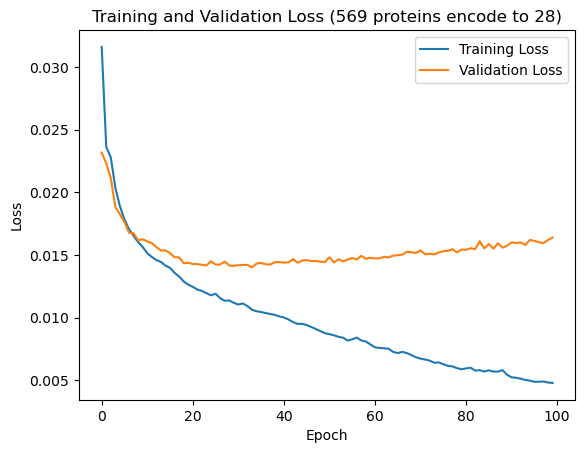

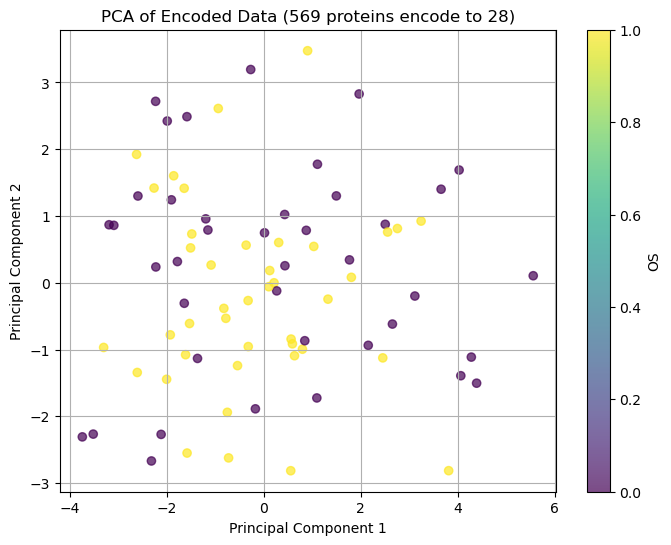

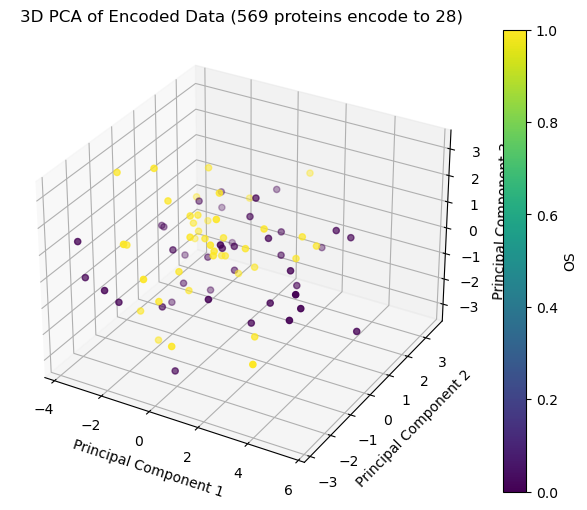

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5721666666666667
LogisticRegression - Mean Confusion Matrix:
[[6.1 5.5]
 [4.9 7.8]]
SVM - Mean CV Score: 0.613
SVM - Mean Confusion Matrix:
[[5.8 5.8]
 [3.6 9.1]]
RandomForest - Mean CV Score: 0.642
RandomForest - Mean Confusion Matrix:
[[7.  4.6]
 [4.1 8.6]]
KNN - Mean CV Score: 0.6095
KNN - Mean Confusion Matrix:
[[7.8 3.8]
 [5.7 7. ]]
GradientBoosting - Mean CV Score: 0.6011666666666666
GradientBoosting - Mean Confusion Matrix:
[[7.2 4.4]
 [5.3 7.4]]
AdaBoost - Mean CV Score: 0.584
AdaBoost - Mean Confusion Matrix:
[[7.1 4.5]
 [5.6 7.1]]
NaiveBayes - Mean CV Score: 0.5518333333333333
NaiveBayes - Mean Confusion Matrix:
[[10.5  1.1]
 [ 9.8  2.9]]
DecisionTree - Mean CV Score: 0.602
DecisionTree - Mean Confusion Matrix:
[[7.6 4. ]
 [5.7 7. ]]
ExtraTrees - Mean CV Score: 0.622
ExtraTrees - Mean Confusion Matrix:
[[6.4 5.2]
 [4.  8.7]]
XGBoost - Mean CV Score: 0.5971666666666667
XGBoost - Mean Confusion Matrix:
[[6.8 4.8]
 [5.  7.7]]
Best classifier

In [63]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0360 
Epoch 1: val_loss improved from inf to 0.02333, saving model to model\(569 proteins encode to 18)_best_model.keras
31/31 [==============================] - 2s 17ms/step - loss: 0.0314 - val_loss: 0.0233
Epoch 2/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0243
Epoch 2: val_loss improved from 0.02333 to 0.02163, saving model to model\(569 proteins encode to 18)_best_model.keras
31/31 [==============================] - 0s 7ms/step - loss: 0.0234 - val_loss: 0.0216
Epoch 3/100
26/31 [========================>.....] - ETA: 0s - loss: 0.0215
Epoch 3: val_loss improved from 0.02163 to 0.01879, saving model to model\(569 proteins encode to 18)_best_model.keras
31/31 [==============================] - 0s 9ms/step - loss: 0.0210 - val_loss: 0.0188
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.0194
Epoch 4: val_loss improved from 0.01879 to 0.01816, saving model to model\(569 p

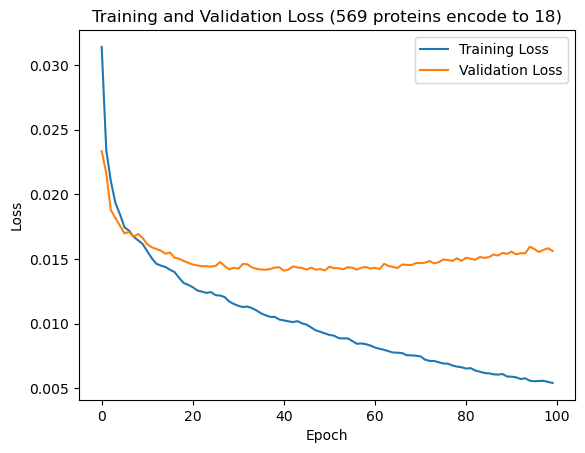

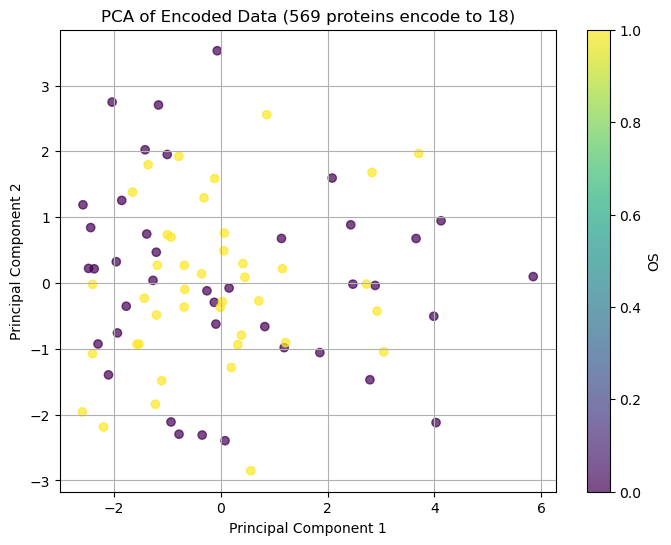

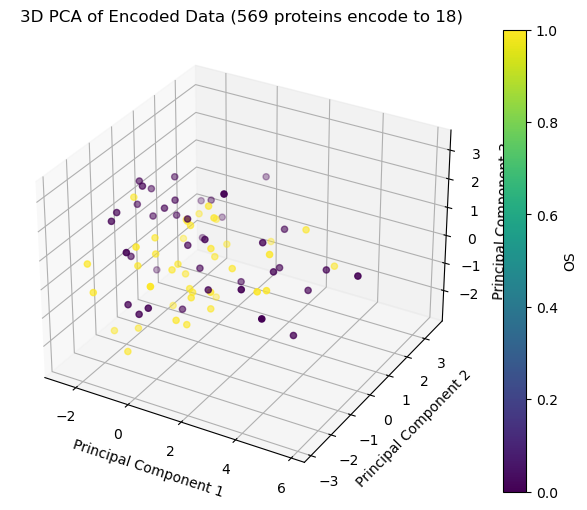

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression - Mean CV Score: 0.5595000000000001
LogisticRegression - Mean Confusion Matrix:
[[6.1 5.5]
 [5.2 7.5]]
SVM - Mean CV Score: 0.6295
SVM - Mean Confusion Matrix:
[[6.  5.6]
 [3.4 9.3]]
RandomForest - Mean CV Score: 0.605
RandomForest - Mean Confusion Matrix:
[[6.4 5.2]
 [4.4 8.3]]
KNN - Mean CV Score: 0.6093333333333333
KNN - Mean Confusion Matrix:
[[7.4 4.2]
 [5.3 7.4]]
GradientBoosting - Mean CV Score: 0.6253333333333333
GradientBoosting - Mean Confusion Matrix:
[[7.1 4.5]
 [4.6 8.1]]
AdaBoost - Mean CV Score: 0.6168333333333333
AdaBoost - Mean Confusion Matrix:
[[7.5 4.1]
 [5.2 7.5]]
NaiveBayes - Mean CV Score: 0.6014999999999999
NaiveBayes - Mean Confusion Matrix:
[[7.3 4.3]
 [5.4 7.3]]
DecisionTree - Mean CV Score: 0.5513333333333332
DecisionTree - Mean Confusion Matrix:
[[6.  5.6]
 [5.3 7.4]]
ExtraTrees - Mean CV Score: 0.6045
ExtraTrees - Mean Confusion Matrix:
[[6.5 5.1]
 [4.5 8.2]]
XGBoost - Mean CV Score: 0.6124999999999999
XGBoost - Mean Confusion Matrix:
[[

In [64]:
WAE_inputation_18d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 18,type = "(569 proteins encode to 18)")
WAE_inputation_18d.train()
WAE_inputation_18d.plot()
WAE_inputation_18d.do_PCA(2)
WAE_inputation_18d.do_PCA(3)
WAE_inputation_18d.cross_validation_model_selection()


Epoch 1/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0342 
Epoch 1: val_loss improved from inf to 0.02304, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 2s 16ms/step - loss: 0.0297 - val_loss: 0.0230
Epoch 2/100
18/31 [================>.............] - ETA: 0s - loss: 0.0235
Epoch 2: val_loss improved from 0.02304 to 0.02241, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0235 - val_loss: 0.0224
Epoch 3/100
26/31 [========================>.....] - ETA: 0s - loss: 0.0228
Epoch 3: val_loss improved from 0.02241 to 0.01916, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 11ms/step - loss: 0.0221 - val_loss: 0.0192
Epoch 4/100
25/31 [=======================>......] - ETA: 0s - loss: 0.0195
Epoch 4: val_loss improved from 0.01916 to 0.01858, saving model to model\(569 

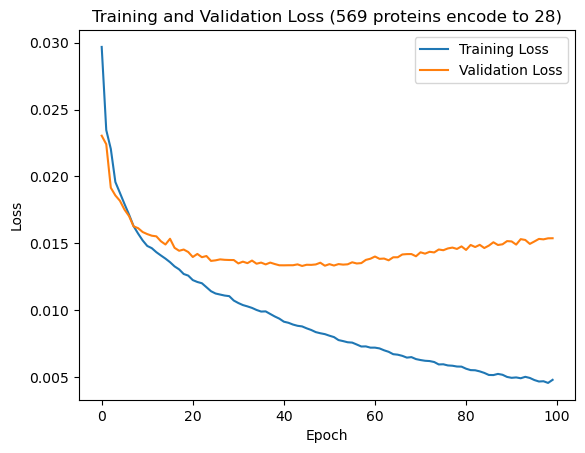

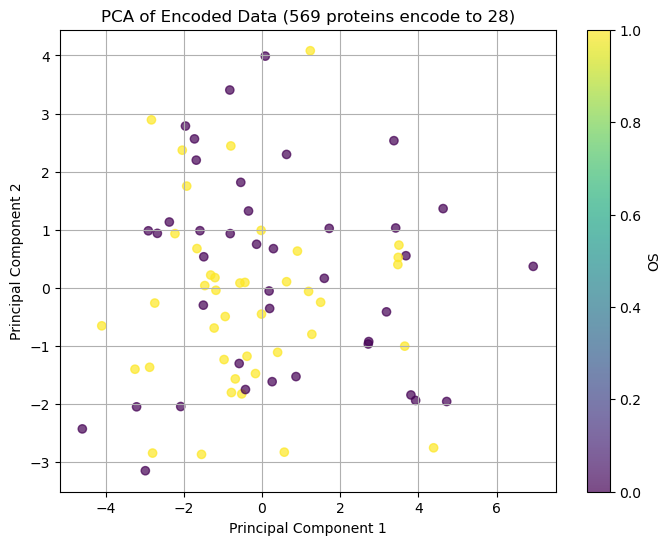

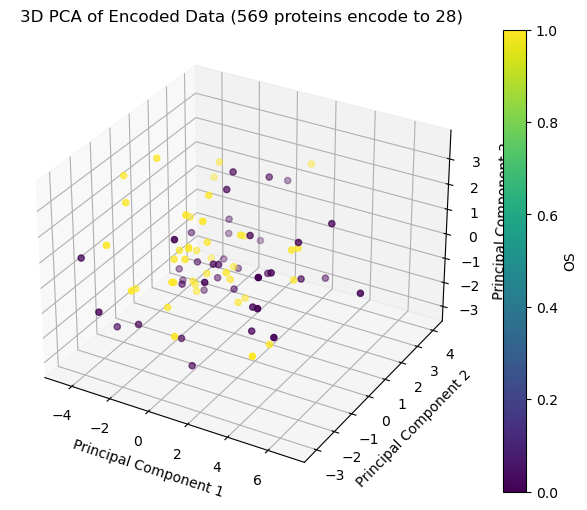

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5638333333333334
LogisticRegression - Mean Confusion Matrix:
[[6.1 5.5]
 [5.1 7.6]]
SVM - Mean CV Score: 0.5963333333333333
SVM - Mean Confusion Matrix:
[[5.8 5.8]
 [4.  8.7]]
RandomForest - Mean CV Score: 0.6335000000000001
RandomForest - Mean Confusion Matrix:
[[6.8 4.8]
 [4.1 8.6]]
KNN - Mean CV Score: 0.5855
KNN - Mean Confusion Matrix:
[[7.4 4.2]
 [5.9 6.8]]
GradientBoosting - Mean CV Score: 0.5476666666666666
GradientBoosting - Mean Confusion Matrix:
[[6.1 5.5]
 [5.5 7.2]]
AdaBoost - Mean CV Score: 0.568
AdaBoost - Mean Confusion Matrix:
[[6.8 4.8]
 [5.7 7. ]]
NaiveBayes - Mean CV Score: 0.4951666666666667
NaiveBayes - Mean Confusion Matrix:
[[10.9  0.7]
 [11.6  1.1]]
DecisionTree - Mean CV Score: 0.6126666666666667
DecisionTree - Mean Confusion Matrix:
[[6.4 5.2]
 [4.2 8.5]]
ExtraTrees - Mean CV Score: 0.6253333333333334
ExtraTrees - Mean Confusion Matrix:
[[7.2 4.4]
 [4.7 8. ]]
XGBoost - Mean CV Score: 0.5715
XGBoost - Mean Confusion Matrix

In [65]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
18/31 [================>.............] - ETA: 0s - loss: 0.0359 
Epoch 1: val_loss improved from inf to 0.02353, saving model to model\(569 proteins encode to 48)_best_model.keras
31/31 [==============================] - 2s 15ms/step - loss: 0.0314 - val_loss: 0.0235
Epoch 2/100
18/31 [================>.............] - ETA: 0s - loss: 0.0240
Epoch 2: val_loss improved from 0.02353 to 0.02155, saving model to model\(569 proteins encode to 48)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0232 - val_loss: 0.0216
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.0207
Epoch 3: val_loss improved from 0.02155 to 0.01905, saving model to model\(569 proteins encode to 48)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0207 - val_loss: 0.0191
Epoch 4/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0190
Epoch 4: val_loss improved from 0.01905 to 0.01840, saving model to model\(569 p

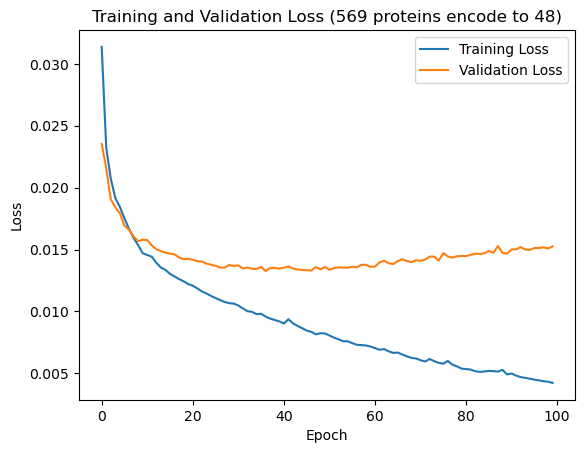

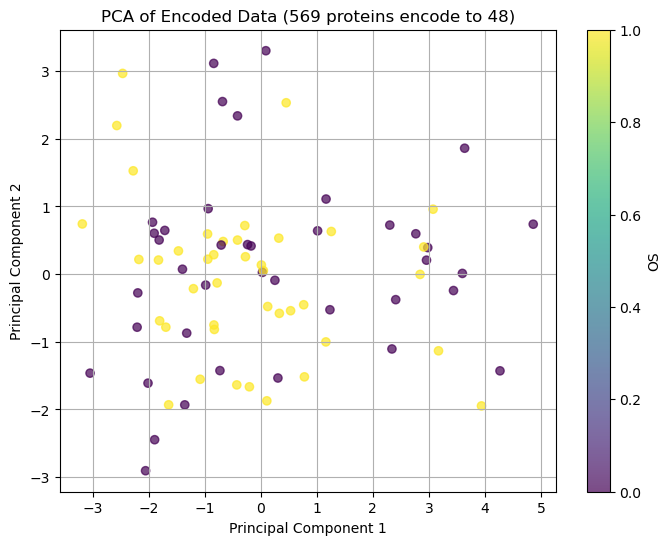

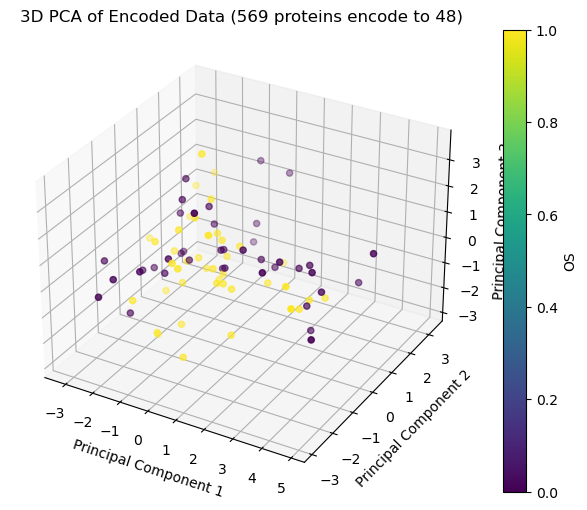

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5630000000000001
LogisticRegression - Mean Confusion Matrix:
[[6.  5.6]
 [5.  7.7]]
SVM - Mean CV Score: 0.5845
SVM - Mean Confusion Matrix:
[[5.6 6. ]
 [4.1 8.6]]
RandomForest - Mean CV Score: 0.6336666666666666
RandomForest - Mean Confusion Matrix:
[[6.7 4.9]
 [4.  8.7]]
KNN - Mean CV Score: 0.5970000000000001
KNN - Mean Confusion Matrix:
[[7.3 4.3]
 [5.5 7.2]]
GradientBoosting - Mean CV Score: 0.6341666666666667
GradientBoosting - Mean Confusion Matrix:
[[7.  4.6]
 [4.3 8.4]]
AdaBoost - Mean CV Score: 0.5355000000000001
AdaBoost - Mean Confusion Matrix:
[[6.  5.6]
 [5.7 7. ]]
NaiveBayes - Mean CV Score: 0.5235000000000001
NaiveBayes - Mean Confusion Matrix:
[[9.8 1.8]
 [9.8 2.9]]
DecisionTree - Mean CV Score: 0.5891666666666666
DecisionTree - Mean Confusion Matrix:
[[6.5 5.1]
 [4.9 7.8]]
ExtraTrees - Mean CV Score: 0.605
ExtraTrees - Mean Confusion Matrix:
[[6.6 5. ]
 [4.6 8.1]]
XGBoost - Mean CV Score: 0.6345000000000001
XGBoost - Mean Confusio

In [66]:
WAE_inputation_48d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 48,type = "(569 proteins encode to 48)")
WAE_inputation_48d.train()
WAE_inputation_48d.plot()
WAE_inputation_48d.do_PCA(2)
WAE_inputation_48d.do_PCA(3)
WAE_inputation_48d.cross_validation_model_selection()


Epoch 1/100
30/31 [============================>.] - ETA: 0s - loss: 0.0305
Epoch 1: val_loss improved from inf to 0.02357, saving model to model\(569 proteins encode to 36)_best_model.keras
31/31 [==============================] - 2s 16ms/step - loss: 0.0305 - val_loss: 0.0236
Epoch 2/100
25/31 [=======================>......] - ETA: 0s - loss: 0.0239
Epoch 2: val_loss improved from 0.02357 to 0.02217, saving model to model\(569 proteins encode to 36)_best_model.keras
31/31 [==============================] - 0s 10ms/step - loss: 0.0235 - val_loss: 0.0222
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.0218
Epoch 3: val_loss improved from 0.02217 to 0.01912, saving model to model\(569 proteins encode to 36)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.0191
Epoch 4/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0191
Epoch 4: val_loss improved from 0.01912 to 0.01778, saving model to model\(569 p

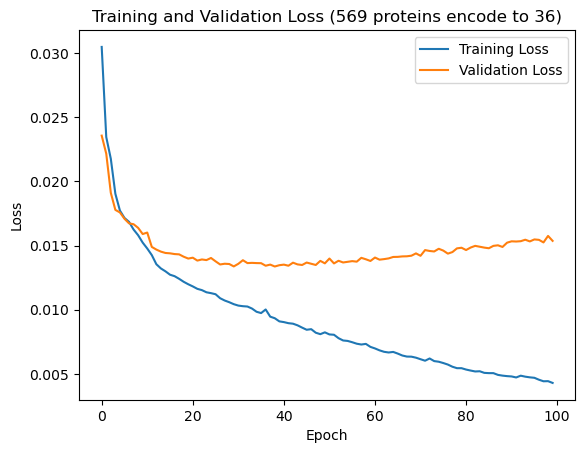

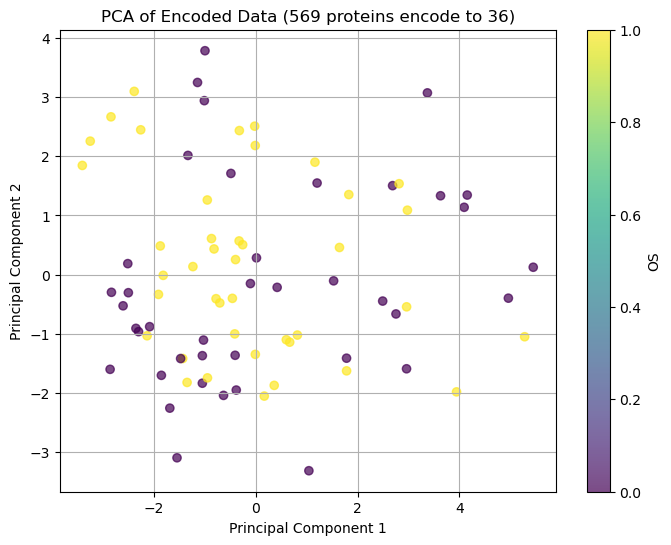

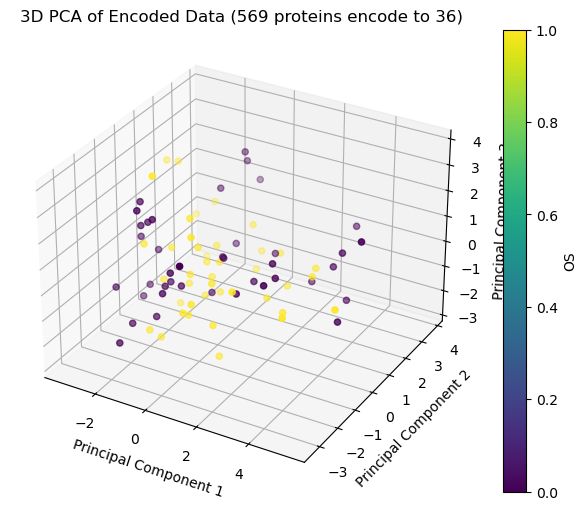

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.6373333333333335
LogisticRegression - Mean Confusion Matrix:
[[6.7 4.9]
 [3.9 8.8]]
SVM - Mean CV Score: 0.617
SVM - Mean Confusion Matrix:
[[6.1 5.5]
 [3.8 8.9]]
RandomForest - Mean CV Score: 0.6668333333333332
RandomForest - Mean Confusion Matrix:
[[7.  4.6]
 [3.5 9.2]]
KNN - Mean CV Score: 0.634
KNN - Mean Confusion Matrix:
[[7.6 4. ]
 [4.9 7.8]]
GradientBoosting - Mean CV Score: 0.6743333333333333
GradientBoosting - Mean Confusion Matrix:
[[7.  4.6]
 [3.3 9.4]]
AdaBoost - Mean CV Score: 0.67
AdaBoost - Mean Confusion Matrix:
[[7.  4.6]
 [3.4 9.3]]
NaiveBayes - Mean CV Score: 0.5730000000000001
NaiveBayes - Mean Confusion Matrix:
[[8.1 3.5]
 [6.9 5.8]]
DecisionTree - Mean CV Score: 0.5421666666666667
DecisionTree - Mean Confusion Matrix:
[[5.9 5.7]
 [5.4 7.3]]
ExtraTrees - Mean CV Score: 0.6503333333333334
ExtraTrees - Mean Confusion Matrix:
[[7.  4.6]
 [3.9 8.8]]
XGBoost - Mean CV Score: 0.6621666666666667
XGBoost - Mean Confusion Matrix:
[[7.1

In [67]:
WAE_inputation_36d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 36,type = "(569 proteins encode to 36)")
WAE_inputation_36d.train()
WAE_inputation_36d.plot()
WAE_inputation_36d.do_PCA(2)
WAE_inputation_36d.do_PCA(3)
WAE_inputation_36d.cross_validation_model_selection()


Epoch 1/100
17/31 [===============>..............] - ETA: 0s - loss: 0.0322 
Epoch 1: val_loss improved from inf to 0.02258, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 2s 17ms/step - loss: 0.0290 - val_loss: 0.0226
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 0.0221
Epoch 2: val_loss improved from 0.02258 to 0.01966, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 8ms/step - loss: 0.0221 - val_loss: 0.0197
Epoch 3/100
26/31 [========================>.....] - ETA: 0s - loss: 0.0195
Epoch 3: val_loss improved from 0.01966 to 0.01886, saving model to model\(569 proteins encode to 28)_best_model.keras
31/31 [==============================] - 0s 10ms/step - loss: 0.0198 - val_loss: 0.0189
Epoch 4/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0191
Epoch 4: val_loss improved from 0.01886 to 0.01810, saving model to model\(569 

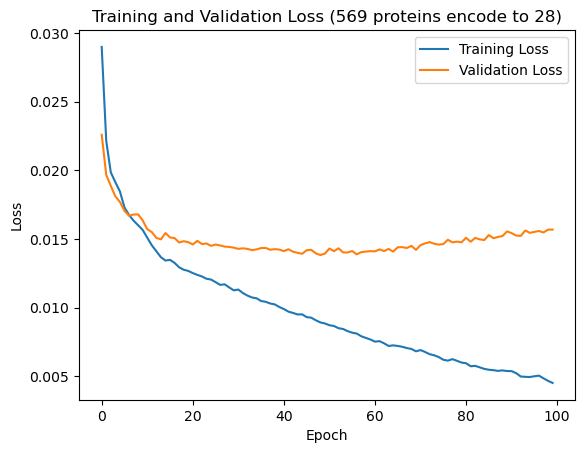

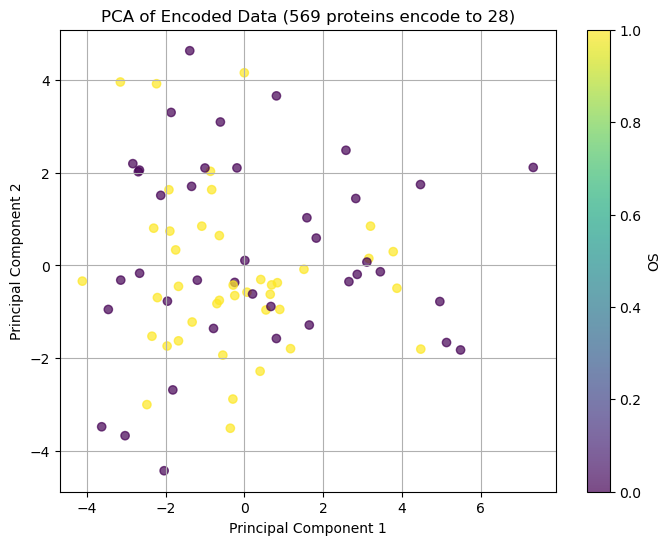

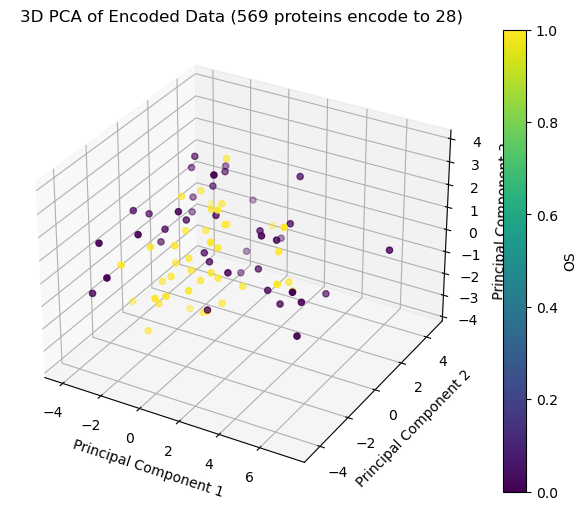

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.596
LogisticRegression - Mean Confusion Matrix:
[[6.4 5.2]
 [4.6 8.1]]
SVM - Mean CV Score: 0.6301666666666667
SVM - Mean Confusion Matrix:
[[6.  5.6]
 [3.4 9.3]]
RandomForest - Mean CV Score: 0.6381666666666667
RandomForest - Mean Confusion Matrix:
[[6.5 5.1]
 [3.7 9. ]]
KNN - Mean CV Score: 0.5968333333333333
KNN - Mean Confusion Matrix:
[[7.  4.6]
 [5.2 7.5]]
GradientBoosting - Mean CV Score: 0.5475000000000001
GradientBoosting - Mean Confusion Matrix:
[[5.6 6. ]
 [5.  7.7]]
AdaBoost - Mean CV Score: 0.539
AdaBoost - Mean Confusion Matrix:
[[5.6 6. ]
 [5.2 7.5]]
NaiveBayes - Mean CV Score: 0.5855
NaiveBayes - Mean Confusion Matrix:
[[8.6 3. ]
 [7.1 5.6]]
DecisionTree - Mean CV Score: 0.5645
DecisionTree - Mean Confusion Matrix:
[[6.6 5. ]
 [5.6 7.1]]
ExtraTrees - Mean CV Score: 0.6426666666666666
ExtraTrees - Mean Confusion Matrix:
[[7.  4.6]
 [4.1 8.6]]
XGBoost - Mean CV Score: 0.5675
XGBoost - Mean Confusion Matrix:
[[5.7 5.9]
 [4.6 8.1]]
Best

In [68]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
26/31 [========================>.....] - ETA: 0s - loss: 0.0320 
Epoch 1: val_loss improved from inf to 0.02353, saving model to model\(569 proteins encode to 34)_best_model.keras
31/31 [==============================] - 3s 20ms/step - loss: 0.0309 - val_loss: 0.0235
Epoch 2/100
26/31 [========================>.....] - ETA: 0s - loss: 0.0237
Epoch 2: val_loss improved from 0.02353 to 0.02160, saving model to model\(569 proteins encode to 34)_best_model.keras
31/31 [==============================] - 0s 10ms/step - loss: 0.0235 - val_loss: 0.0216
Epoch 3/100
26/31 [========================>.....] - ETA: 0s - loss: 0.0213
Epoch 3: val_loss improved from 0.02160 to 0.01893, saving model to model\(569 proteins encode to 34)_best_model.keras
31/31 [==============================] - 0s 9ms/step - loss: 0.0211 - val_loss: 0.0189
Epoch 4/100
27/31 [=========================>....] - ETA: 0s - loss: 0.0194
Epoch 4: val_loss improved from 0.01893 to 0.01828, saving model to model\(569 

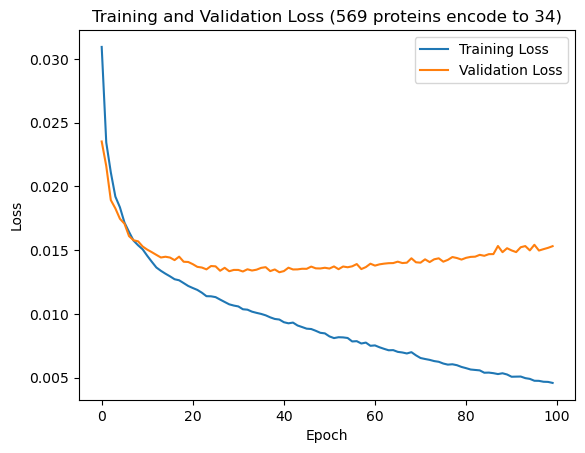

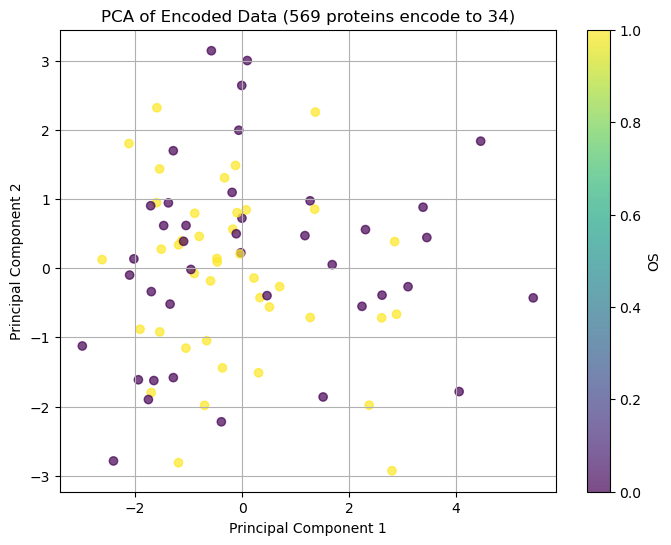

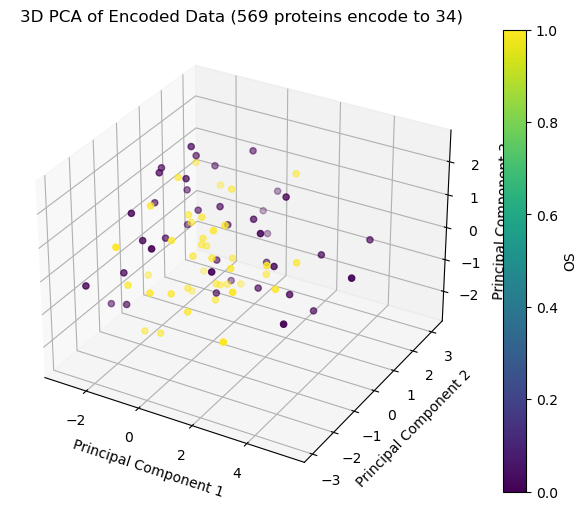

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

LogisticRegression - Mean CV Score: 0.5763333333333334
LogisticRegression - Mean Confusion Matrix:
[[6.1 5.5]
 [4.8 7.9]]
SVM - Mean CV Score: 0.6298333333333334
SVM - Mean Confusion Matrix:
[[6.7 4.9]
 [4.1 8.6]]
RandomForest - Mean CV Score: 0.6541666666666666
RandomForest - Mean Confusion Matrix:
[[7.2 4.4]
 [4.  8.7]]
KNN - Mean CV Score: 0.6345000000000001
KNN - Mean Confusion Matrix:
[[7.7 3.9]
 [5.  7.7]]
GradientBoosting - Mean CV Score: 0.6301666666666665
GradientBoosting - Mean Confusion Matrix:
[[7.2 4.4]
 [4.6 8.1]]
AdaBoost - Mean CV Score: 0.659
AdaBoost - Mean Confusion Matrix:
[[7.  4.6]
 [3.7 9. ]]
NaiveBayes - Mean CV Score: 0.5976666666666667
NaiveBayes - Mean Confusion Matrix:
[[7.9 3.7]
 [6.1 6.6]]
DecisionTree - Mean CV Score: 0.5768333333333333
DecisionTree - Mean Confusion Matrix:
[[6.6 5. ]
 [5.3 7.4]]
ExtraTrees - Mean CV Score: 0.6631666666666667
ExtraTrees - Mean Confusion Matrix:
[[7.9 3.7]
 [4.5 8.2]]
XGBoost - Mean CV Score: 0.6676666666666666
XGBoost - M

In [69]:
WAE_inputation_34d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 34,type = "(569 proteins encode to 34)")
WAE_inputation_34d.train()
WAE_inputation_34d.plot()
WAE_inputation_34d.do_PCA(2)
WAE_inputation_34d.do_PCA(3)
WAE_inputation_34d.cross_validation_model_selection()


# Resources Investigation:

ICGC:
https://dcc.icgc.org/repositories?filters=%7B%22file%22:%7B%20%22projectCode%22:%7B%22is%22:%5B%22HNSC-US%22%5D%7D%7D%7D

 Data Type
 SSM  2,126
 Aligned Reads  2,037
 Clinical Data  453
 Biospecimen Data  448
 StSM  223
 SGV  132
 CNSM  88
 StGV  88

TCPA:
https://www.tcpaportal.org/tcpa/download.html

TCGA of 2018, with L4(normalized across RPPA batches therefore enable pan-cancer)

PDC:
https://proteomic.datacommons.cancer.gov/pdc/browse
3 studies, but Mass Spectrum not RPPA, therefore only contains Peptide result. do have clinincal though

HNSCC PDX: 
https://aacrjournals.org/mcr/article/14/3/278/89624/Proteomic-Characterization-of-Head-and-Neck-Cancer
RPPA, but on mention how to acess and probabaly wound not have clinical since the read from transplated rats.

HAP: Reference RNA and protein from healthy samples:
https://www.proteinatlas.org/about/download

Pride:Full MS sets
https://www.ebi.ac.uk/pride/archive?keyword=HNSCC,RPPA&sortDirection=DESC&page=0&pageSize=20

Paper HNSCC: RPPA but only target 60 specific protein
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070553/

GEO: Some Protein profiling by protein array (RPPA), no HNSCC
https://www.ncbi.nlm.nih.gov/geo/browse/

ArraryExpress: RPPA for GBM, lung cancer, breast cancer
https://www.ebi.ac.uk/biostudies/arrayexpress/studies?query=RPPA

FANTOM6 Experiment Index: RNA-Seq
https://fantom.gsc.riken.jp/6/experiment_index/#/

Resources index: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6971871/